In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
import pickle

### Data Gen

In [ ]:
! mkdir VALIDATION
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/images.raw.gz
! wget https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/track_parms.csv
! mv images.raw.gz VALIDATION
! mv track_parms.csv VALIDATION

import os
import sys
import gzip
import pandas as pd
import numpy as np
import math

width  = 36
height = 100

# Open labels files so we can get number of samples and pass the
# data frames to the generators later
valdf = pd.read_csv('VALIDATION/track_parms.csv')
STEP_SIZE_VAL = len(valdf)/32

#-----------------------------------------------------
# generate_arrays_from_file
#-----------------------------------------------------
# Create generator to read in images and labels
# (used for both training and validation samples)
def generate_arrays_from_file( labelsdf , dType):

	images_path = dType+'images.raw.gz'
	print( 'generator created for: ' + images_path)

	batch_input           = []
	batch_labels_phi      = []
	batch_labels_z        = []
	idx = 0
	ibatch = 0
	while True:  # loop forever, re-reading images from same file
		with gzip.open(images_path) as f:
			while True: # loop over images in file
			
				# Read in one image
				bytes = f.read(width*height)
				if len(bytes) != (width*height): break # break into outer loop so we can re-open file
				data = np.frombuffer(bytes, dtype='B', count=width*height)
				pixels = np.reshape(data, [width, height, 1], order='F')
				pixels_norm = np.transpose(pixels.astype(np.float) / 255., axes=(1, 0, 2) )
				
				# Labels
				phi = labelsdf.phi[idx]
				z   = labelsdf.z[idx]
				idx += 1

				# Add to batch and check if it is time to yield
				batch_input.append( pixels_norm )
				batch_labels_phi.append( phi )
				batch_labels_z.append( z )
				if len(batch_input) == 32 :
					ibatch += 1
					
					# Since we are training multiple loss functions we must
					# pass the labels back as a dictionary whose keys match
					# the layer their corresponding values are being applied to.
					labels_dict = {
						'phi_output' :  np.array(batch_labels_phi ),
						'z_output'   :  np.array(batch_labels_z   ),		
					}
					
					yield ( np.array(batch_input), labels_dict )
					batch_input      = []
					batch_labels_phi = []
					batch_labels_z   = []

			idx = 0
			f.close()


--2020-10-08 18:03:48--  https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/images.raw.gz
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3182266 (3.0M) [application/x-gzip]
Saving to: ‘images.raw.gz’

images.raw.gz       100%[===================>]   3.03M  12.6MB/s    in 0.2s    

2020-10-08 18:03:49 (12.6 MB/s) - ‘images.raw.gz’ saved [3182266/3182266]

--2020-10-08 18:03:49--  https://halldweb.jlab.org/talks/ML_lunch/May2019/VALIDATION/track_parms.csv
Resolving halldweb.jlab.org (halldweb.jlab.org)... 129.57.64.128
Connecting to halldweb.jlab.org (halldweb.jlab.org)|129.57.64.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3893164 (3.7M) [text/csv]
Saving to: ‘track_parms.csv’

track_parms.csv     100%[===================>]   3.71M  13.6MB/s    in 0.3s    

2020-10-08 18:03:49 (13.6 MB/s) -

### Plotting

In [ ]:
model = keras.models.load_model("drive/My Drive/model.keras")
with open('drive/My Drive/history.pkl', 'rb') as input:
  history = pickle.load(input)
  
try:
  with open('drive/My Drive/data.pkl', 'rb') as input:
    data = pickle.load(input)
except FileNotFoundError:
  print("WARN: File 'data' not found")


WARN: File 'data' not found


dict_keys(['loss', 'phi_output_loss', 'z_output_loss', 'phi_output_mae', 'z_output_mae', 'val_loss', 'val_phi_output_loss', 'val_z_output_loss', 'val_phi_output_mae', 'val_z_output_mae'])


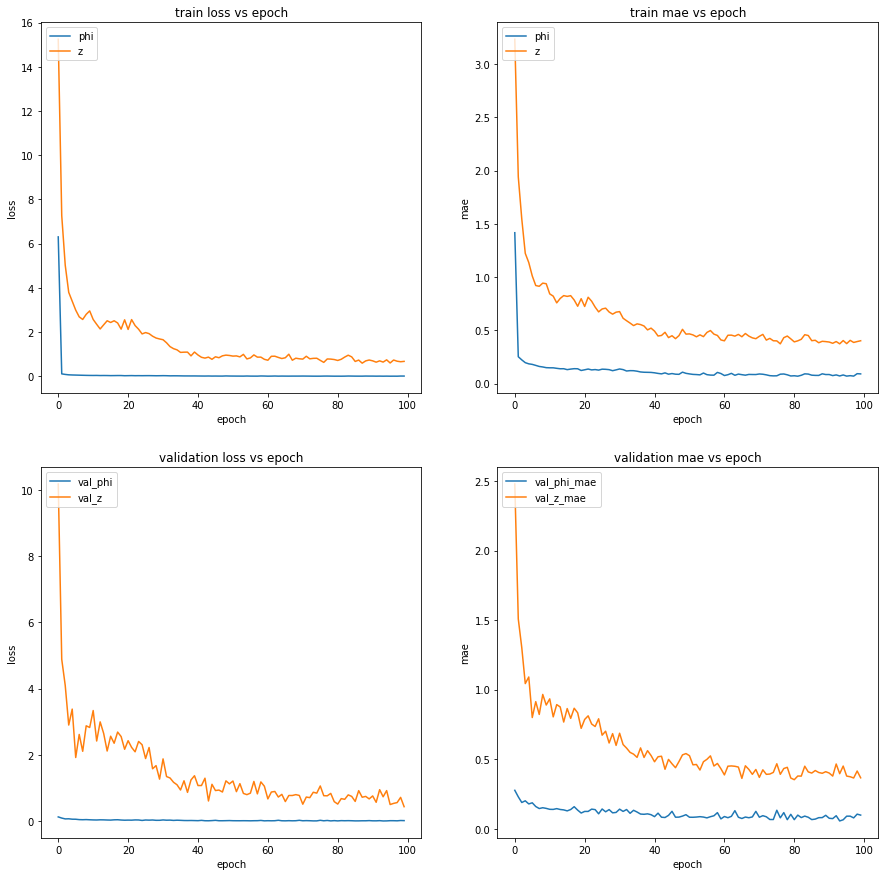

In [ ]:
print(history.keys())
try:
  fig, axs = plt.subplots(2,2,figsize=(15,15))

  axs[0,0].plot(history['phi_output_loss'])
  axs[0,0].plot(history['z_output_loss'])
  axs[0,0].set_title('train loss vs epoch')
  axs[0,0].set_ylabel('loss')
  axs[0,0].set_xlabel('epoch')
  axs[0,0].legend(['phi','z'],loc='upper left')

  axs[0,1].plot(history['phi_output_mae'])
  axs[0,1].plot(history['z_output_mae'])
  axs[0,1].set_title('train mae vs epoch')
  axs[0,1].set_ylabel('mae')
  axs[0,1].set_xlabel('epoch')
  axs[0,1].legend(['phi','z'],loc='upper left')

  axs[1,0].plot(history['val_phi_output_loss'])
  axs[1,0].plot(history['val_z_output_loss'])
  axs[1,0].set_title('validation loss vs epoch')
  axs[1,0].set_ylabel('loss')
  axs[1,0].set_xlabel('epoch')
  axs[1,0].legend(['val_phi','val_z'],loc='upper left')

  axs[1,1].plot(history['val_phi_output_mae'])
  axs[1,1].plot(history['val_z_output_mae'])
  axs[1,1].set_title('validation mae vs epoch')
  axs[1,1].set_ylabel('mae')
  axs[1,1].set_xlabel('epoch')
  axs[1,1].legend(['val_phi_mae','val_z_mae'],loc='upper left')

except e:
  print("error:")
  print(e)

In [ ]:
if 'data' not in globals():
  print("generating new data")
  test_generator = generate_arrays_from_file(valdf,"VALIDATION/")
  diff_phi = np.array([])
  diff_phi_err = np.array([])
  diff_z = np.array([])
  diff_z_err = np.array([])
  z_t = np.array([])
  phi_t = np.array([])
  z_e = np.array([])
  phi_e = np.array([])
  ev = model.evaluate(test_generator,steps=100,batch_size=32)

  for i in range(20):
    test = next(test_generator)
    test = np.array(test)
    test_x = test[0]
    test_y = test[1]

    pred = model.predict(x=test_x,verbose=0)

    prt = False

    if prt: print("phi:::\n")
    for i in range(25):
      true = np.reshape(test_y["phi_output"],[32,1])[i]
      exp = pred["phi_output"][i]
      phi_t = np.append(phi_t,true)
      phi_e = np.append(phi_e,exp)

      diff_phi = np.append(diff_phi,exp-true)
      diff_phi_err = np.append(diff_phi_err,((abs(exp-true)/true)*100))

      if prt: print(exp," : ",true," : ",diff_phi[-1])

    if prt: print("\n\nz::::\n")
    for i in range(25):
      true = np.reshape(test_y["z_output"],[32,1])[i]
      exp = pred["z_output"][i]
      z_t = np.append(z_t,true)
      z_e = np.append(z_e,exp)

      diff_z = np.append(diff_z,exp-true)
      diff_z_err = np.append(diff_z_err,((abs(exp-true)/true)*100))

      if prt: print(exp," : ",true," : ",diff_z[-1])


generating new data
generator created for: VALIDATION/images.raw.gz
100/100 [==============================] - 4s 38ms/step - loss: 0.0906 - phi_output_loss: 0.0166 - z_output_loss: 0.6678 - phi_output_mean_absolute_error: 0.1023 - z_output_mean_absolute_error: 0.3962


(-1.5, 1.5)

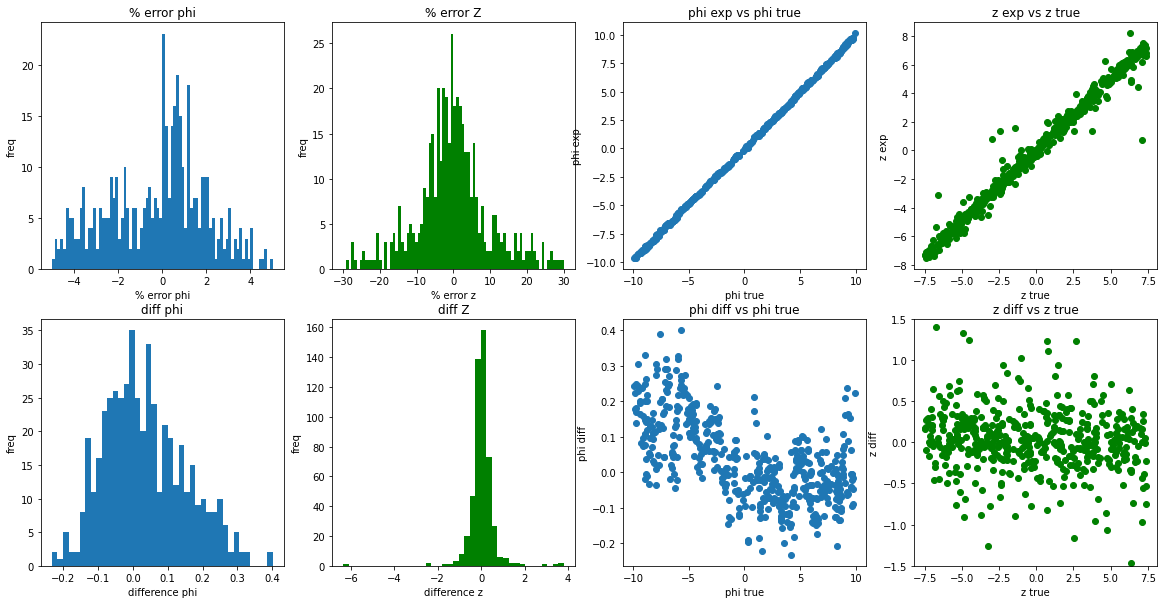

In [ ]:
# diff_phi = data[0]
# diff_phi_err = data[1]
# diff_z = data[2]
# diff_z_err = data[3]
# z_t = data[4]
# phi_t = data[5]
# z_e = data[6]
# phi_e = data[7]

fig, axs = plt.subplots(2,4,figsize=(20,10))

# axs[0,0].hist(diff_phi_err,80,[-100,100])
axs[0,0].hist(diff_phi_err,80,[-5,5])
axs[0,0].set_title('% error phi')
axs[0,0].set_ylabel('freq')
axs[0,0].set_xlabel('% error phi')

# axs[0,1].hist(diff_z_err,80,[-100,100],color='g')
axs[0,1].hist(diff_z_err,80,[-30,30],color='g')
axs[0,1].set_title('% error Z')
axs[0,1].set_ylabel('freq')
axs[0,1].set_xlabel('% error z')

axs[1,0].hist(diff_phi,40)
axs[1,0].set_title('diff phi')
axs[1,0].set_ylabel('freq')
axs[1,0].set_xlabel('difference phi')

axs[1,1].hist(diff_z,40,color='g')
axs[1,1].set_title('diff Z')
axs[1,1].set_ylabel('freq')
axs[1,1].set_xlabel('difference z')


axs[0,2].scatter(phi_t,phi_e)
axs[0,2].set_title('phi exp vs phi true')
axs[0,2].set_ylabel('phi exp')
axs[0,2].set_xlabel('phi true')

axs[0,3].scatter(z_t,z_e,color='g')
axs[0,3].set_title('z exp vs z true')
axs[0,3].set_ylabel('z exp')
axs[0,3].set_xlabel('z true')

axs[1,2].scatter(phi_t, phi_e-phi_t)
axs[1,2].set_title('phi diff vs phi true')
axs[1,2].set_ylabel('phi diff')
axs[1,2].set_xlabel('phi true')

axs[1,3].scatter(z_t, z_e-z_t,color='g')
axs[1,3].set_title('z diff vs z true')
axs[1,3].set_ylabel('z diff')
axs[1,3].set_xlabel('z true')
axs[1,3].set_ylim([-1.5,1.5])



